In [313]:
import numpy as np
import matplotlib.pyplot as plt
from diametery.fiber import Image
from scipy.optimize import curve_fit
#from sklearn.metrics import mean_squared_error

In [314]:
def get_coordinates(im, value_for_mask):
    #I = rgb2gray(I_orig) #we can delete this if we get binary images
    mask = im > value_for_mask
    fiber_coor = np.argwhere(mask)
    x = fiber_coor[:, 1]
    y = fiber_coor[:, 0]
    return x, y

def func_line(x, a, b):
    return a * x + b
def func_line_inv(y, a, b):
    return (y - b)/a

def create_fiber():
    image = Image.create()
    im = image.render_image()
    return im, image.fiber.diameter

def get_fited_line_x_y(im):
    value_for_mask = (int(np.max(im))+int(np.min(im)))/2 # Pixels to mask in get_coordinate
    x, y = get_coordinates(im, value_for_mask)
    popt, pcov = curve_fit(func_line, x, y)
    return x, y, popt, pcov
def get_fited_line_y_x(im):
    value_for_mask = (int(np.max(im))+int(np.min(im)))/2 # Pixels to mask in get_coordinate
    x, y = get_coordinates(im, value_for_mask)
    popt, pcov = curve_fit(func_line, y, x)
    return x, y, popt, pcov

def get_better_fit(x, popt, popt_inv, pcov, pcov_inv):
    diagonal = np.diagonal(pcov)
    diagonal_inv = np.diagonal(pcov_inv)
    if np.less(diagonal, diagonal_inv).all() == True:
        popt_fit = popt
        x_line = np.arange(0, max(x), 1)
        y_line = []
        for i in x_line:
            a = func_line(x_line[i], *popt)
            y_line.append(a)
        y_fit = y_line
        x_fit = x_line
        p1 = [x_fit[0],y_fit[0]]
        p2 = [x_fit[-1],y_fit[-1]]
    elif np.less(diagonal, diagonal_inv).all() == False:
        popt_fit = [1/popt_inv[0], (-popt_inv[1])/popt_inv[0]]
        y_line = np.arange(0, max(y), 1)
        x_line = []
        for i in y_line:
            a = func_line(y_line[i], *popt_inv)
            x_line.append(a)
        y_fit = y_line
        x_fit = x_line
        p1 = [x_fit[0],y_fit[0]]
        p2 = [x_fit[-1],y_fit[-1]]
    else:
        print("One of the pcov values is True and the rest are False")
    return popt_fit, x_fit, y_fit, p1, p2

def get_point(t, p1, p2):
    dx = p2[0]-p1[0]
    dy = p2[1]-p1[1]
    p = [(dx * t + p1[0]), (dy * t + p1[1])]
    return p, dx, dy

def get_normal_vector(t, dx, dy, p3):
    n_pos = [-dy, dx]
    mag_pos = np.linalg.norm(n_pos)
    nu_pos = n_pos/mag_pos
    u_pos = [(nu_pos[0] * t + p3[0]), (nu_pos[1] * t + p3[1])]
    return u_pos


The calculated diameter is : 48.888888888888886
The true diameter is : 49


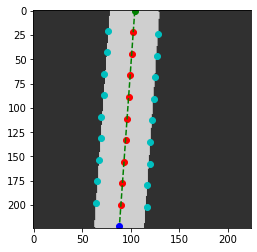

In [330]:
im, true_diameter = create_fiber()
plt.imshow(im, vmax=255, vmin=0, cmap='gray')
x, y, popt, pcov = get_fited_line_x_y(im)
_, _, popt_inv, pcov_inv = get_fited_line_y_x(im)
popt_fit, x_fit, y_fit, p1, p2 = get_better_fit(x, popt, popt_inv, pcov, pcov_inv)

measurements = 10
half = (int(np.max(im))+int(np.min(im)))/2
all_pixels_n = []
all_pixels_p = []
all_pixels = []

for n in range(1, measurements): 
    t = 1/measurements 
    p3, dx1, dy1 = get_point((t * n), p1, p2)
    for ts in (range(len(im[0]))):
        u_pos = get_normal_vector((ts+(0.5)), dx1, dy1, p3)
        test = im[round(u_pos[1]),round(u_pos[0])] > half
        if test == False:
            pixels_p = ts - 1
            break
    plt.plot(p3[0], p3[1], 'r.', markersize=12)
    plt.plot(u_pos[0], u_pos[1], 'c.', markersize=12)
    all_pixels_p.append(pixels_p)
    for ts in (range(len(im[0]))):
        u_pos = get_normal_vector((-(ts+(0.5))), dx1, dy1, p3)
        test = im[round(u_pos[1]),round(u_pos[0])] > half
        if test == False:
            pixels_n = ts - 1
            break
    plt.plot(u_pos[0], u_pos[1], 'c.', markersize=12)
    all_pixels_n.append(pixels_n)

    all_pixels = (np.array(all_pixels_p) + np.array(all_pixels_n)).mean()
    

calculated_diameter = all_pixels
print("The calculated diameter is :", calculated_diameter)
print("The true diameter is :", true_diameter) 
    #b = bajo = 0 = False [y, x] 
    # sample in t < 1 and round up 


plt.plot(x_fit, y_fit, 'g--')
plt.plot(p1[0], p1[1], 'g.', markersize=12)
plt.plot(p2[0], p2[1], 'b.', markersize=12)

plt.show()
